In [1]:
# Importing modules

import pandas as pd
import numpy as np

## visualization 
import matplotlib.pyplot as plt
import seaborn as sns

## modelling and testing
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.simplefilter(action='ignore') ## ignoring warning


In [2]:
gas_prices = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
gas_prices_orignal = gas_prices.copy()
gas_prices.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [3]:
gas_prices.isna().sum()

Dates     0
Prices    0
dtype: int64

In [4]:
gas_prices['months'] = gas_prices['Dates'].dt.month
gas_prices['year'] = gas_prices['Dates'].dt.year
gas_prices.tail()


,Dates,Prices,months,year
43,2024-05-31,11.4,5,2024
44,2024-06-30,11.5,6,2024
45,2024-07-31,11.6,7,2024
46,2024-08-31,11.5,8,2024
47,2024-09-30,11.8,9,2024


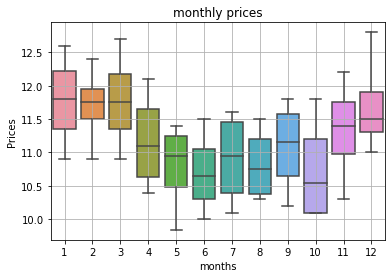

In [5]:
sns.boxplot(x = 'months', y = 'Prices', data = gas_prices).set_title('monthly prices')
plt.grid()
plt.show()

Text(0.5, 1.0, 'year wise prices')

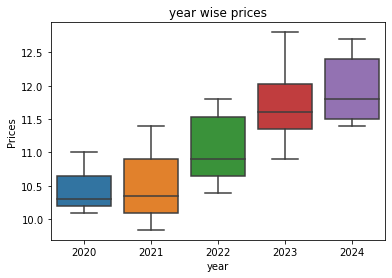

In [6]:
sns.boxplot(x = 'year', y = 'Prices', data = gas_prices).set_title('year wise prices')

<AxesSubplot:>

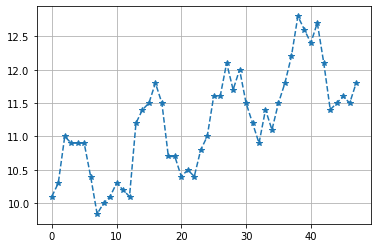

In [7]:
gas_prices['Prices'].plot(grid = True, marker = '*', linestyle = '--')

In [8]:
gas_prices['monthly_returns'] = gas_prices['Prices'].pct_change()

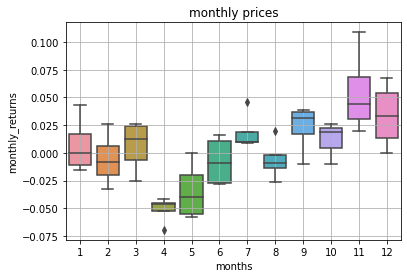

In [9]:
sns.boxplot(x = 'months', y = 'monthly_returns', data = gas_prices).set_title('monthly prices')
plt.grid()

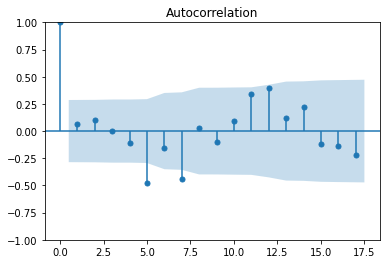

In [10]:
_ = plot_acf(gas_prices['monthly_returns'].dropna())

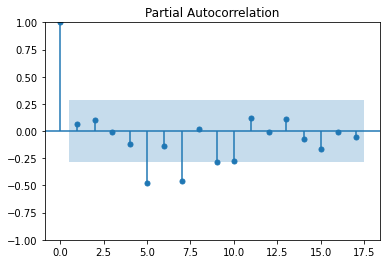

In [11]:
_ = plot_pacf(gas_prices['monthly_returns'].dropna())

In [12]:
adfuller(gas_prices.monthly_returns.dropna()) ## stationary

(-6.824443471200037,
 1.964148194014749e-09,
 9,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 -164.7531376463014)

## creating an AR(7) model

In [13]:
## from scratch using ols
gas_prices['monthly_returns_lag_7'] = gas_prices.monthly_returns.shift(7)
gas_prices['monthly_returns_lag_5'] = gas_prices.monthly_returns.shift(5)
gas_prices = gas_prices.dropna()


In [14]:

Y = gas_prices.monthly_returns
X = gas_prices[['monthly_returns_lag_5', 'monthly_returns_lag_7']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

const                    0.008892
monthly_returns_lag_5   -0.394043
monthly_returns_lag_7   -0.449609
dtype: float64

In [15]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        monthly_returns   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     14.19
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           2.67e-05
Time:                        00:28:36   Log-Likelihood:                 89.668
No. Observations:                  40   AIC:                            -173.3
Df Residuals:                      37   BIC:                            -168.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.00

In [16]:
adfuller(results.resid) ## residuals are stationary

(-6.569881223773364,
 7.98537385209456e-09,
 1,
 38,
 {'1%': -3.6155091011809297,
  '5%': -2.941262357486514,
  '10%': -2.6091995013850418},
 -143.24140374182707)

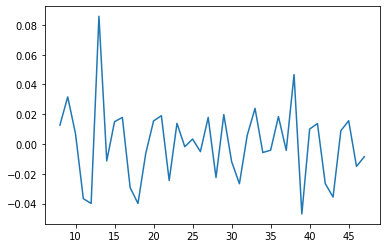

In [17]:
plt.plot(results.resid)

In [18]:
y_all_pred = results.predict(sm.add_constant(gas_prices[['monthly_returns_lag_7', 'monthly_returns_lag_5']]))
gas_prices['predicted_return'] = y_all_pred

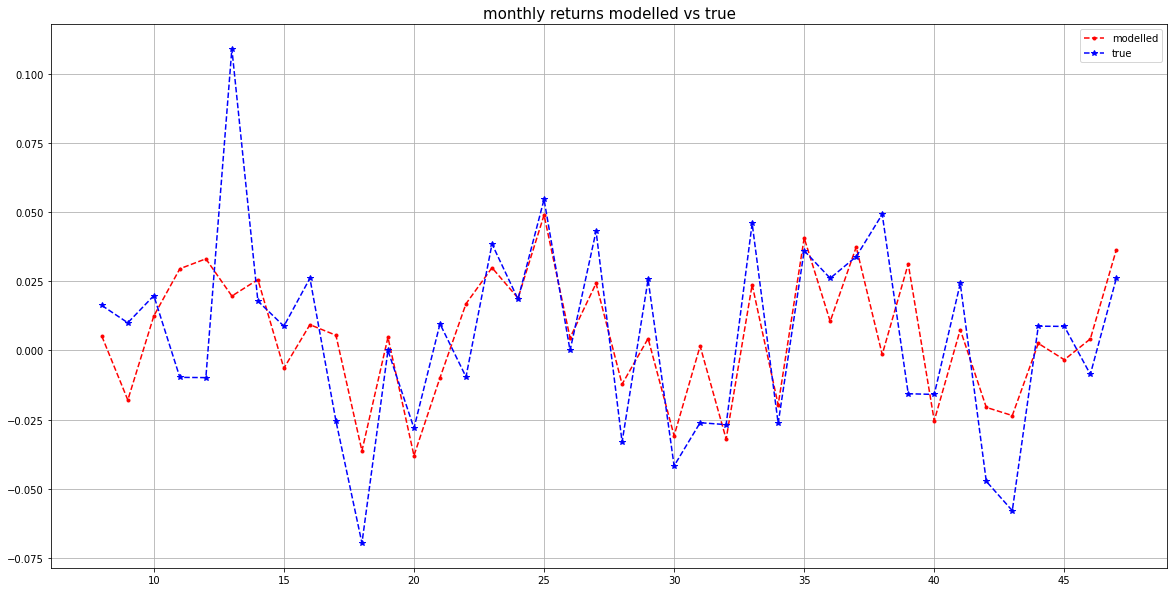

In [19]:
plt.figure(figsize = (20,10))
plt.plot(y_all_pred, marker = '.', linestyle = '--', color = 'r', label = 'modelled')
plt.plot(gas_prices.monthly_returns, marker = '*', linestyle = '--', color = 'b', label = 'true')
plt.grid()
plt.title('monthly returns modelled vs true', size = 15)
plt.legend()


In [20]:
## reversing prices from forecasted returns
gas_prices['predicted_price'] = gas_prices.Prices.shift(1) *(1 + gas_prices.predicted_return)

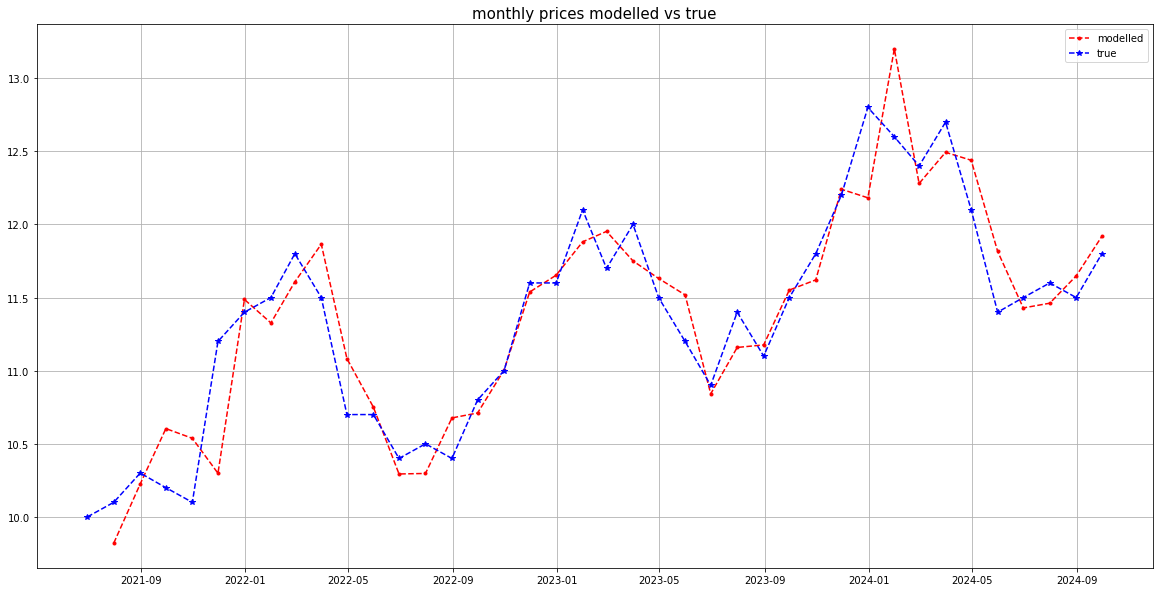

In [21]:
plt.figure(figsize = (20,10))
plt.plot(gas_prices.Dates.to_list(), gas_prices.predicted_price.to_list(), marker = '.', linestyle = '--', color = 'r', label = 'modelled')
plt.plot(gas_prices.Dates.to_list(),gas_prices.Prices.to_list(), marker = '*', linestyle = '--', color = 'b', label = 'true')
plt.grid()
plt.title('monthly prices modelled vs true', size = 15)
plt.legend()

In [22]:
mse = mean_squared_error(y_pred=gas_prices.dropna().predicted_price, y_true = gas_prices.dropna().Prices)

In [23]:
mse

0.0844792260279922

## instead of modelling returns what if we detrend and remove seasonality by modelling it and then seperately model the noise?

- time_series = trend + seasonality + noise

-> model all three differently

In [24]:
gas_prices_orignal.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


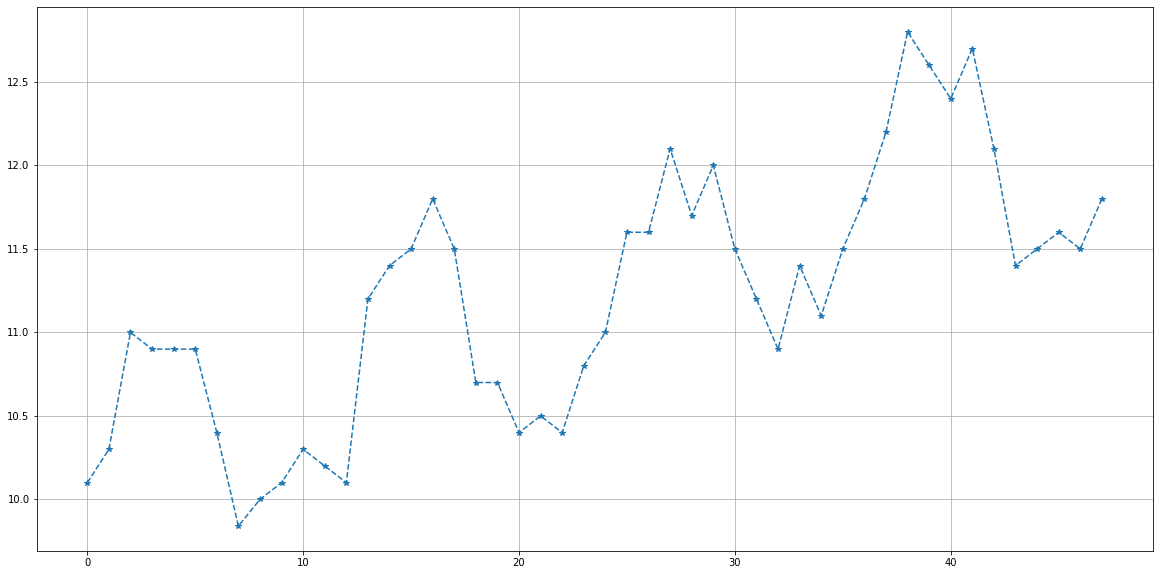

In [25]:
## looking at periods of seasonality: fixed period or not in months
plt.figure(figsize=  (20,10))
plt.plot(gas_prices_orignal.Prices, marker = '*', linestyle = '--')
plt.grid()

### looking at the trend

Text(0.5, 1.0, 'year wise prices')

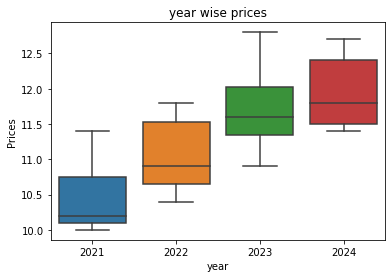

In [26]:
gas_prices_orignal['months'] = gas_prices_orignal['Dates'].dt.month
gas_prices_orignal['year'] = gas_prices_orignal['Dates'].dt.year
sns.boxplot(x = 'year', y = 'Prices', data = gas_prices).set_title('year wise prices')

## linear trend: modelling it

In [27]:
gas_prices_orignal['days_since'] = np.cumsum([0] + [int(str(k).split(' ')[0]) for k in (gas_prices_orignal.Dates - gas_prices_orignal.Dates.shift(1))[1:]])
gas_prices_orignal.head()

,Dates,Prices,months,year,days_since
0,2020-10-31,10.1,10,2020,0
1,2020-11-30,10.3,11,2020,30
2,2020-12-31,11.0,12,2020,61
3,2021-01-31,10.9,1,2021,92
4,2021-02-28,10.9,2,2021,120


In [28]:
## regressing on time to estimate linear trend

Y = gas_prices_orignal.Prices
X = gas_prices_orignal['days_since']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results_linear = model.fit()
linear_trend = results_linear.predict(sm.add_constant(gas_prices_orignal.days_since))
results_linear.params

const         10.291041
days_since     0.001282
dtype: float64

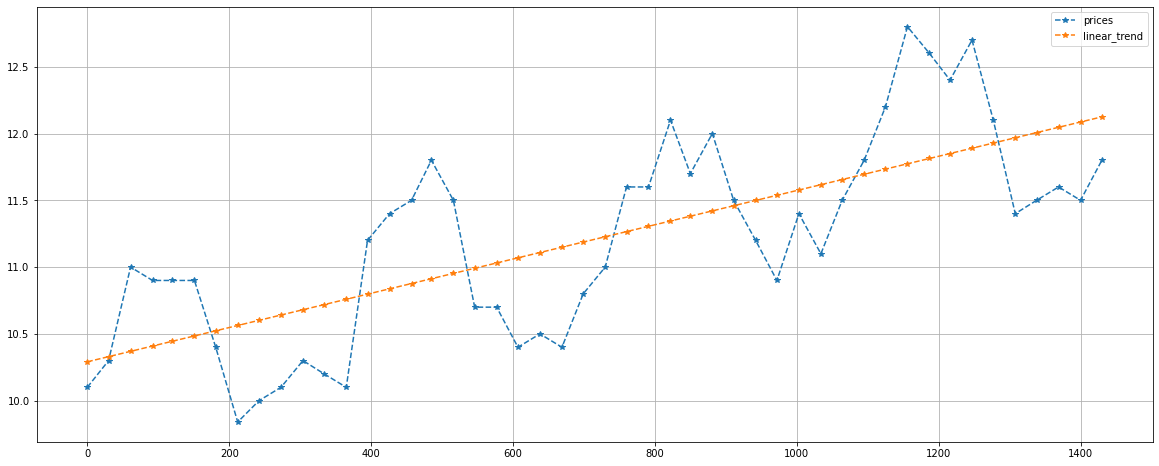

In [29]:
plt.figure(figsize=(20,8))
plt.plot(gas_prices_orignal.days_since.to_list(),gas_prices_orignal.Prices.to_list(), marker = '*',linestyle = '--', label = 'prices')
plt.plot(gas_prices_orignal.days_since.to_list(), linear_trend.to_list(), marker = '*',linestyle = '--', label = 'linear_trend')
plt.grid()
plt.legend()

In [30]:
gas_prices_orignal['trend'] = linear_trend

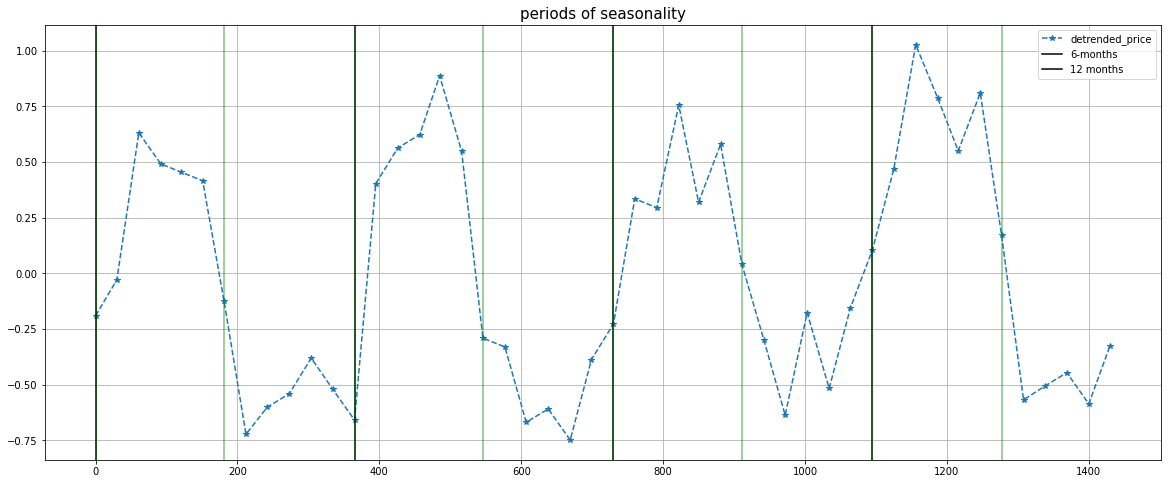

In [31]:
detrended_price = gas_prices_orignal.Prices-linear_trend
gas_prices_orignal['detrended_price'] = detrended_price
plt.figure(figsize=(20,8))
plt_1 = plt.plot((gas_prices_orignal.days_since).to_list(), detrended_price.to_list(),  marker = '*',linestyle = '--', label = 'detrended prices')

## no. of days to mark 12 month periods
years = [gas_prices_orignal.days_since[k] for k in range(len(gas_prices_orignal.days_since)) if k%12 == 0]
semi_years = [gas_prices_orignal.days_since[k] for k in range(len(gas_prices_orignal.days_since)) if k%6 == 0]

for year in years:
    _ = plt.axvline(year, color = 'black', label = '12-months')

for semi in semi_years:
    _ = plt.axvline(semi, color = 'green', alpha = 0.5, label = '6-months')

plt.grid()
plt.legend(['detrended_price','6-months', '12 months'])
plt.title('periods of seasonality', size = 15)
plt.show()

## period of seasonality = 12 months
- makes sence since energy prices increase in winters and decrease in summers due  to fluctuation in demnad

In [32]:
## creating sine and cosine terms for 1st order fourier computation and a seperate term to experiment interaction between sine and cosine terms 
gas_prices_orignal['sin_seasonality'] = np.sin(2*np.pi*gas_prices_orignal.days_since/365)
gas_prices_orignal['cos_seasonality'] = np.cos(2*np.pi*gas_prices_orignal.days_since/365)
gas_prices_orignal['interaction_seasonality'] = gas_prices_orignal.sin_seasonality * gas_prices_orignal.cos_seasonality

In [33]:
## modeling using order 1 fourier transform

Y = gas_prices_orignal.detrended_price
X = gas_prices_orignal[['sin_seasonality']]
X = sm.add_constant(X)
model_sin = sm.OLS(Y,X)
results_sin = model_sin.fit()
seasonality_sin = results_sin.predict(sm.add_constant(gas_prices_orignal[['sin_seasonality']]))
results_sin.params

const             -0.003115
sin_seasonality    0.664533
dtype: float64

In [34]:
## modeling using sine only without an intercept

Y = gas_prices_orignal.detrended_price
X = gas_prices_orignal[['sin_seasonality']]

model_sin = sm.OLS(Y,X)
results_sin_no_const = model_sin.fit()
seasonality_sin_no_const = results_sin_no_const.predict(gas_prices_orignal[['sin_seasonality']])
results_sin_no_const.params


sin_seasonality    0.664503
dtype: float64

In [35]:
## modeling using order 1 fourier transform and a bit of variants.

Y = gas_prices_orignal.detrended_price
X = gas_prices_orignal[['sin_seasonality', 'cos_seasonality']]
X = sm.add_constant(X)
model_sin_cos = sm.OLS(Y,X)
results_season_sin_cos = model_sin_cos.fit()
seasonality_sin_cos = results_season_sin_cos.predict(sm.add_constant(gas_prices_orignal[['sin_seasonality', 'cos_seasonality']]))
results_season_sin_cos.params


const             -0.003162
sin_seasonality    0.664369
cos_seasonality   -0.038591
dtype: float64

In [36]:
## modeling using order 1 fourier transform

Y = gas_prices_orignal.detrended_price
X = gas_prices_orignal[['sin_seasonality', 'cos_seasonality', 'interaction_seasonality']]
X = sm.add_constant(X)
model_interaction = sm.OLS(Y,X)
results_season_interaction = model_interaction.fit()
seasonality_interaction = results_season_interaction.predict(sm.add_constant(gas_prices_orignal[['sin_seasonality', 'cos_seasonality', 'interaction_seasonality']]))
results_season_interaction.params


const                     -0.003398
sin_seasonality            0.663950
cos_seasonality           -0.038692
interaction_seasonality   -0.112090
dtype: float64

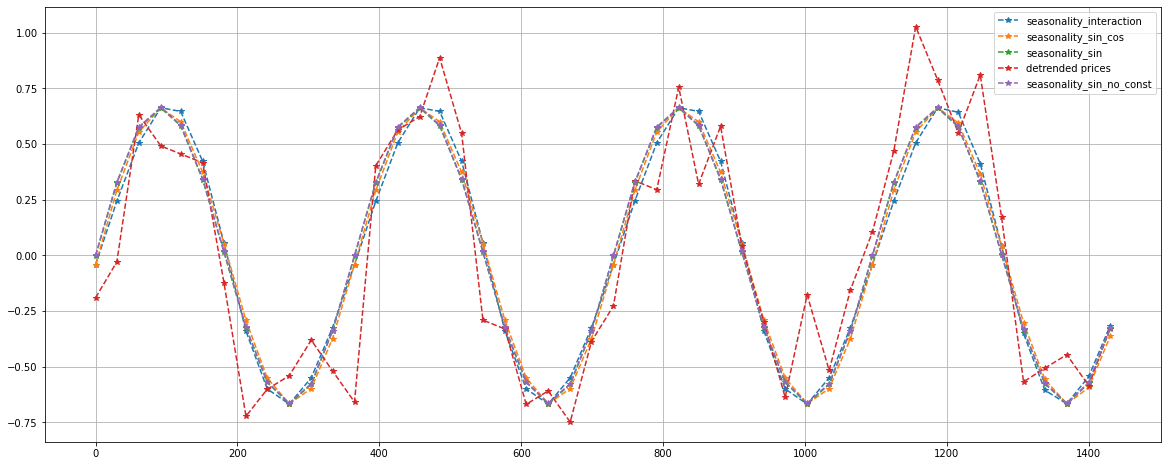

In [37]:
plt.figure(figsize=(20,8))
plt_1 = plt.plot((gas_prices_orignal.days_since).to_list(), seasonality_interaction.to_list(),  marker = '*',linestyle = '--', label = 'seasonality_interaction')
plt_2 = plt.plot((gas_prices_orignal.days_since).to_list(), seasonality_sin_cos.to_list(),  marker = '*',linestyle = '--', label = 'seasonality_sin_cos')
plt_3 = plt.plot((gas_prices_orignal.days_since).to_list(), seasonality_sin.to_list(),  marker = '*',linestyle = '--', label = 'seasonality_sin')
plt_4 = plt.plot((gas_prices_orignal.days_since).to_list(), detrended_price.to_list(),  marker = '*',linestyle = '--', label = 'detrended prices')
plt_5 = plt.plot((gas_prices_orignal.days_since).to_list(), seasonality_sin_no_const.to_list(),  marker = '*',linestyle = '--', label = 'seasonality_sin_no_const')


plt.legend()
plt.grid()
plt.show()

## all are equally inefficient, using the least complex

In [38]:
gas_prices_orignal['seasonality_sin'] = seasonality_sin

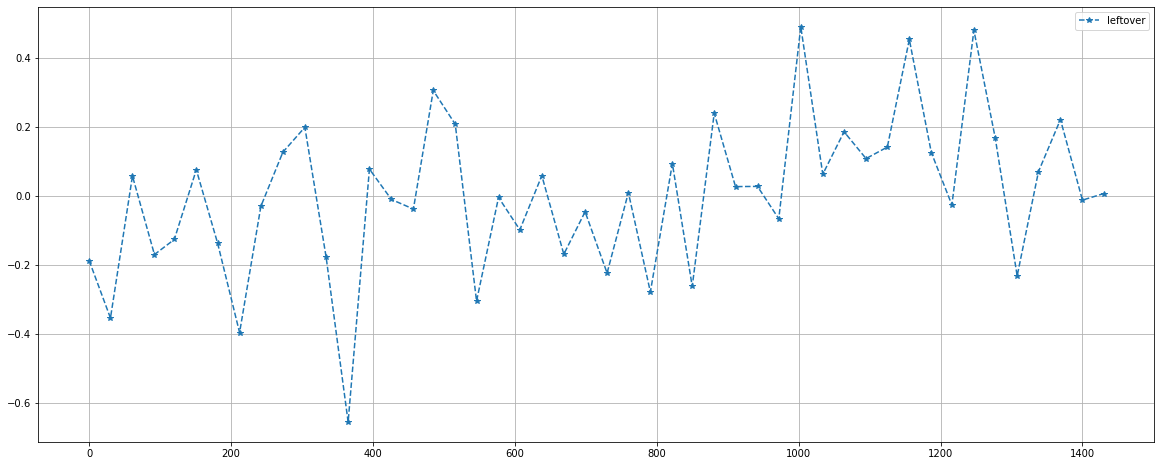

In [39]:
plt.figure(figsize=(20,8))
plt_1 = plt.plot((gas_prices_orignal.days_since).to_list(), np.array(detrended_price.to_list()) - np.array(seasonality_sin.to_list()) ,  marker = '*',linestyle = '--', label = 'leftover')
# plt_2 = plt.plot((gas_prices.days_since).to_list(), seasonality.to_list(),  marker = '*',linestyle = '--', label = 'seasonality')
plt.legend()
plt.grid()
plt.show()

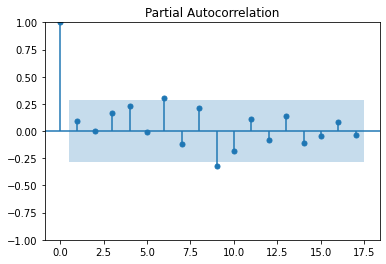

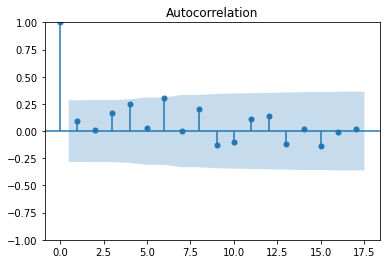

In [40]:
## plotting pacf and acf of residuals
_ = plot_pacf(np.array(detrended_price.to_list()) - np.array(seasonality_sin.to_list()))
_ = plot_acf(np.array(detrended_price.to_list()) - np.array(seasonality_sin.to_list()))

<AxesSubplot:ylabel='Density'>

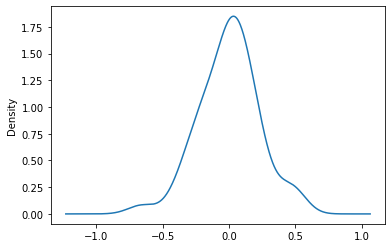

In [41]:
pd.Series(np.array(detrended_price.to_list()) - np.array(seasonality_sin.to_list())).plot.kde()

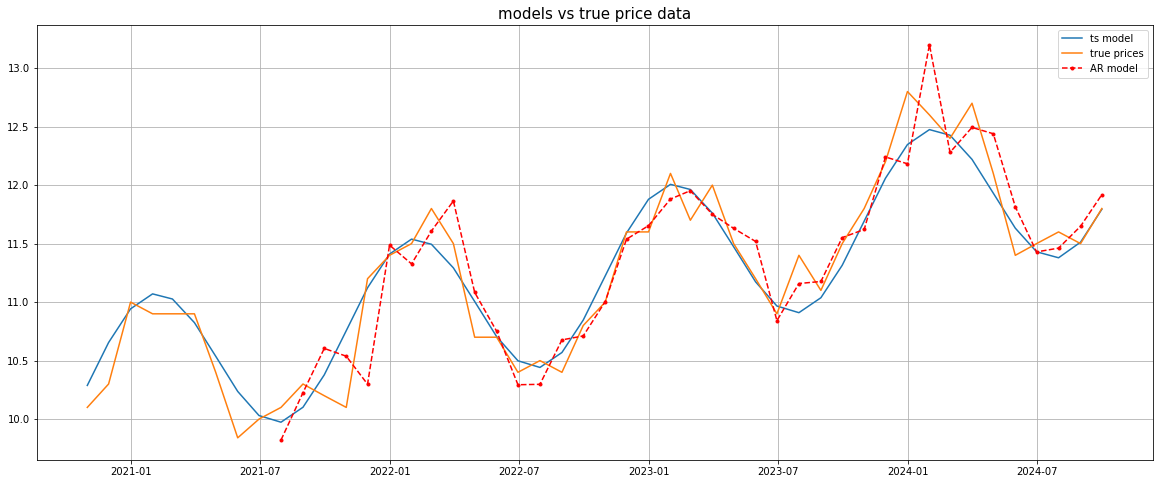

In [42]:

plt.figure(figsize=(20,8))
plt.plot(gas_prices_orignal.Dates.to_list(), (gas_prices_orignal.trend + np.array(gas_prices_orignal.seasonality_sin.to_list())).to_list(), label = 'ts model')
plt.plot(gas_prices_orignal.Dates.to_list(),gas_prices_orignal.Prices.to_list(), label = 'true prices')
plt.plot(gas_prices.Dates.to_list(),gas_prices.predicted_price.to_list(), marker = '.', linestyle = '--', color = 'r', label = 'AR model')

plt.title('models vs true price data', size = 15)
plt.grid()
plt.legend()
plt.show()

In [43]:
gas_prices.dropna(inplace=True)

In [44]:
## comparing the two models.
mse_ar = mean_squared_error(y_pred=gas_prices.predicted_price, y_true = gas_prices.Prices)
mse_ts = mean_squared_error(y_pred= gas_prices_orignal.trend + np.array(gas_prices_orignal.seasonality_sin.to_list()), y_true = gas_prices_orignal.Prices)

print('mse_ts: ', mse_ts)
print('mse_ar: ', mse_ar)

mse_ts:  0.04913454417524723
mse_ar:  0.0844792260279922


In [45]:

r2_ar = r2_score(y_pred=gas_prices.predicted_price, y_true = gas_prices.Prices)
r2_ts = r2_score(y_pred= gas_prices_orignal.trend + np.array(gas_prices_orignal.seasonality_sin.to_list()), y_true = gas_prices_orignal.Prices)


print('r2_ts: ', r2_ts)
print('r2_ar: ', r2_ar)

r2_ts:  0.912640612789224
r2_ar:  0.8315112339191523


## final model = ts, since it does better than AR in sample. Data too little to test out of sample.

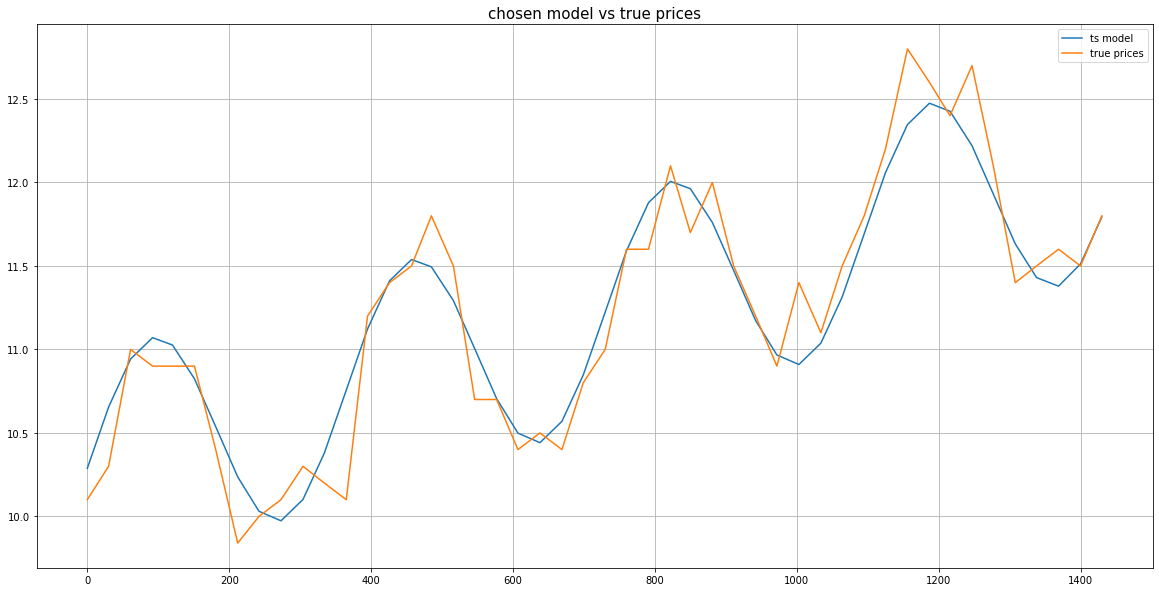

In [49]:
plt.figure(figsize = (20,10))
plt.plot(gas_prices_orignal.days_since.to_list(), (gas_prices_orignal.trend + np.array(gas_prices_orignal.seasonality_sin.to_list())).to_list(), label = 'ts model')
plt.plot(gas_prices_orignal.days_since.to_list(),gas_prices_orignal.Prices.to_list(), label = 'true prices')
plt.title('chosen model vs true prices', size = 15)
plt.legend()
plt.grid()
plt.show()

In [50]:
## final daily prices(interpolated and extrapolated)
interpolated_prices = results_linear.predict(sm.add_constant([k for k in range(1500)])) + results_sin.predict(sm.add_constant(np.sin(2*np.pi* np.array([k/365 for k in range(1500)]))))

# End of script
CLEAN AND SUBMIT!!